In [1]:
from jax import grad
import pickle
import jax.numpy as jnp
import os
from IPython.core.display import HTML
#this css file can be downloaded from [David's repo](https://github.com/ketch/PseudoSpectralPython/blob/master/custom.css)
#Then set the address of css file as per your address of file
#Following two commands are not needed for calculations.
css_file = '/Users/rajvanmp/Downloads/custom.css'

#HTML(open(css_file, "r").read())

In [2]:
from scipy import integrate
import sympy as sp
import numpy as np
import sys
from numpy import linalg as la 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
matplotlib.rcParams['animation.embed_limit'] = 2**128


HTML(open(css_file, "r").read())
font = {'size'   : 15}
matplotlib.rc('font', **font)
#from RKSchemes import ImEx_schemes

fft = np.fft.fft
ifft = np.fft.ifft

from IPython.display import HTML
css_file = '/Users/rajvanmp/Downloads/custom.css'

In [3]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

In [4]:
def test(x,n="real"):
    if n=="real":
        return jnp.real(jnp.exp(1j*x))
    else:
        return jnp.imag(jnp.exp(1j*x))
dx_test = grad(test)

In [5]:




fft = np.fft.fft
ifft = np.fft.ifft


In [6]:
#Choose ImEx scheme

def choose_imex(imex_scheme="default"):
    from Biswas_Ketcheson_TimeIntegrators import ImEx_schemes

    if imex_scheme=="default":
        print("Choosin default ImEx")
        A_ex    = np.array([[0,0,0],[5/6.,0,0],[11/24,11/24,0]])
        A_im = np.array([[2./11,0,0],[205/462.,2./11,0],[2033/4620,21/110,2/11]])
        b_ex = np.array([24/55.,1./5,4./11])
        b_im = b_ex     
        C=None
        imex_stages=3
    if imex_scheme=="a":
        #3rd order ImEx with b This method is taken from Implicit-explicit 
        # Runge-Kutta methods for time-dependent partial differential equations by Ascher, Steven Ruuth and Spiteri.
        print("Using 3rd order ImEx with b  This method is taken from Implicit-explicit Runge-Kutta methods for time-dependent partial differential equations by Ascher, Steven Ruuth and Spiteri.")

        A_im,A_ex,C,b_im,b_oth = ImEx_schemes(4,3,2,2)
        b_ex = b_im
        imex_stages=4

    if imex_scheme=="b":
        #3rd order ImEx with b. This method is taken from Additive Runge–Kutta schemes 
        #for convection–diffusion–reaction equations by Kennedy and Carpenter.
        print("Using 3rd order ImEx with b . This method is taken from Additive Runge–Kutta schemes for convection–diffusion–reaction equations by Kennedy and Carpenter.")
        A_im,A_ex,C,b_im,b_oth = ImEx_schemes(4,3,2,3)
        b_ex = b_im
        imex_stages=4
    if imex_scheme=="c":
        #4th order ImEx with b and 3rd order ImEx with bhat. This method is taken from Additive Runge–Kutta schemes 
        #for convection–diffusion–reaction equations by Kennedy and Carpenter.
        print("4th order ImEx with b. This method is taken from Additive Runge–Kutta scheme for convection–diffusion–reaction equations by Kennedy and Carpenter.")
        A_im,A_ex,C,b_im,b_oth = ImEx_schemes(6,4,3,4)
        b_ex = b_im
        imex_stages=6

    return A_im,A_ex,C,b_im,b_ex,imex_stages



In [7]:
np.power(100.0,-np.inf)

0.0

In [8]:
def Lp_norm(f,p):
    abs_f = np.abs(f)
  
    if p<1:
        print("L^p Error, p should be >=1")
        norm = None

    elif p==1:

        norm = np.mean(abs_f)
    elif p==np.inf:
        norm = np.max(abs_f)
    else:
        p = float(p)
        norm = np.mean(np.power(abs_f,p))
        norm = np.power(norm,1.0/p)
    return  norm

In [9]:
def rhs_linear(uft,u,xi,tau,kppa):
    #Evaluate the linear term
    m = len(xi)
    #rho = u[:m]; q = u[m:];
    q0 = u[:,0]
    q1 = u[:,1]
    v = np.zeros_like(u)
    q0hat = uft[:,0]
    q1hat = uft[:,1]
    q0_x = ifft(1j*xi*q0hat)
   #q0_xx = ifft(-xi*xi*q0hat)
    q1_x = ifft(1j*xi*q1hat)
    rhs_q0 = 1j*q1_x
    rhs_q1 = 1j*(-q0_x+q1)/tau
    v[:,0] = rhs_q0; v[:,1] = rhs_q1
    return v

def dxi_u(uft,u,xi,i):
    q0hat = uft[:,0]
    q1hat = uft[:,1]

    v = np.zeros_like(u)

    dxi_q0 = ifft(np.power(1j*xi,i)*q0hat)
    dxi_q1 = ifft(np.power(1j*xi,i)*q1hat)

    v[:,0] = dxi_q0; v[:,1] = dxi_q1

    return v


In [10]:
def rhs_nonlinear(u,uft, xi,tau,kppa):
    #Evaluate the nonlinear term
    m = len(xi)
    q0 = u[:,0]; q1 = u[:,1]
    v = np.zeros_like(u)
    q0_rhs = 1j*kppa*np.square(np.abs(q0))*q0
    q1_rhs = np.zeros_like(q0_rhs)
    
    v[:,0] = q0_rhs; v[:,1] = q1_rhs
    return v

In [11]:
def I1(u,xi,kppa,tau):
   
    q0 = u[:,0]
    q1 = u[:,1]

    q0sqr = np.square(np.abs(q0))
    q1sqr = np.square(np.abs(q1))

    return -0.5*np.sum(q0sqr+tau*q1sqr)

def I2(u,xi,kppa,tau):
    uft = np.zeros_like(u)
    uft[:,0] = np.fft.fft(u[:,0])
    uft[:,1] = np.fft.fft(u[:,1])
    q0 = u[:,0]
    q1 = u[:,1]

    v = np.real(q0)
    w = np.imag(q0)

    p = np.real(q1)
    q = np.imag(q1)

    u_x = dxi_u(uft,u,xi,1.0)

    v_x = np.real(u_x[:,0])
    w_x = np.imag(u_x[:,0])

    p_x = np.real(u_x[:,1])
    q_x = np.imag(u_x[:,1])

    return 0.5*np.sum(v*w_x-w*v_x+tau*(p*q_x-q*p_x))

def H(u,xi,kppa,tau):
    uft = np.zeros_like(u)
    uft[:,0] = np.fft.fft(u[:,0])
    uft[:,1] = np.fft.fft(u[:,1])
    q0 = u[:,0]
    q1 = u[:,1]

    v = np.real(q0)
    w = np.imag(q0)

    p = np.real(q1)
    q = np.imag(q1)

    u_x = dxi_u(uft,u,xi,1.0)

    v_x = np.real(u_x[:,0])
    w_x = np.imag(u_x[:,0])

    p_x = np.real(u_x[:,1])
    q_x = np.imag(u_x[:,1])

    return np.sum(v_x*p+w_x*q - 0.5*( np.square(p) + np.square(q) ) - 0.25*kppa*np.square( np.square(v) + np.square(w) ))




In [12]:
sys.path.append('/Users/rajvanmp/station_X/pyGP_fields')

In [13]:
from GPE import GPE_scalar_field
from GPE import ImEx
from GPE import GPE_scalar_field_1d2c

In [14]:


def setup_tau(imx,dt,xi,tau):
    lmda_list=[]
    chklist=[]
    for s in range(imx.s):
        impf = imx.im_A[s][s]
        print(s,imx.s,impf,tau)
        omega = xi*dt*impf
        bta = -xi*dt*impf/tau
        chk = np.ones_like(xi)
    
        l = [[[chk[i],omega[i]],[bta[i],(chk[i]-1j*dt*impf/tau)]] for i in range(len(xi))]
        a=chk
        b=omega
        c = bta
        d = (chk-1j*dt*impf/tau)
        det_M = a*d-b*c
        
        l_inv = np.array( [ [[d[i]/det_M[i],-b[i]/det_M[i]],[-c[i]/det_M[i],a[i]/det_M[i]]] for i in range(len(xi))])
        mt_inv = l_inv
    #l = [[[1.0+impf*dt*1j*np.square(xi[i]),0.0 ],[bta[i],(chk[i]-1j*dt)/tau]] for i in range(len(xi))]

        mt = np.array(l)
        #print("shape check",mt.shape,mt_inv.shape)
        #chklist.append(np.matmul(mt,mt_inv))
        lmdamat = mt_inv#np.linalg.inv(mt)

        lmda_list.append(lmdamat)
    print(mt.shape, mt.dtype,lmdamat.shape,q0_ini.shape,q1_ini.shape,u_ini.shape)

    return lmda_list#,chklist

def run_nls_hyper_example(dt,x,xi,kppa,T,tau,lmda_list,imx,inv_list,exact_soln_np=None):
    
    
    tmax = T

    

    num_plots = 50
    nplt = np.floor((tmax/num_plots)/dt)
    nmax = int(round(tmax/dt))
    #print(nplt,"nmax",nmax)
    
   
    mass_ini = np.sum(np.square(np.abs(q0_ini)))

    frames = [u_ini,]
   
    tt = [0,]
    err_l = []
    mass_l = []
    mass_err_l=[]
    
    rhoq = GPE_scalar_field_1d2c(m,2,rhs_linear,rhs_nonlinear,imx,u_ini)

    inv_ini = [f(u_ini,xi,kppa,tau) for f in inv_list]
    print("Ini invariant", inv_ini)
    
    
    for n in range(0,nmax):
        
        #print(n)
        for k in range(imx.s):
            rhoq.update_stage_sum(k,dt)
            
            rhoq.do_fft(k,lmda_list[k],dt)
            
            rhoq.update_K(k,xi,tau,kppa)
           
            
            
            
        rhoq.sum_contributions(dt)
        
        
        
        t = (n+1)*dt
        

        
        
        if np.mod(n,nplt) == 0:
            frames.append(rhoq.psi)
            
            tt.append(t)
            
            #err = sol_err(psi.psi,t,nx,T,max_err)
           # err_l.append(err)
            
           # mass = psi_1.calc_mass()+psi_2.calc_mass()
           # mass_err = (mass-mass_ini)/mass_ini
            
          ##  mass_l.append(mass)
           # mass_err_l.append(mass_err)
            
            #print("time ",t/tmax,t)
            
    u = rhoq.psi
    sol = exact_soln_np(t*np.ones_like(x),x,kppa)
    q0_diff = u[:,0]-sol
    q0_err_Linf= Lp_norm(q0_diff,np.inf)
    q0_err_L1 = Lp_norm(q0_diff,1)
    q0_err_L2 = Lp_norm(q0_diff,2)
    
    errs = [q0_err_L1,q0_err_L2,q0_err_Linf]
    inv_fin = [f(u,xi,kppa,tau) for f in inv_list]

    inv_change_relative = [np.abs((ini-fin)/(ini+1e-12) )for ini,fin in zip(inv_ini,inv_fin)]
    inv_change = [np.abs(ini-fin) for ini,fin in zip(inv_ini,inv_fin)]
    inv_change_dic = {"change":inv_change,"relative change":inv_change_relative}
    #err =  sol_err(psi.psi,t,nx,T,max_err)
    #err_l.append(err)
            
   # mass = psi_1.calc_mass()+psi_2.calc_mass()
    #mass_err = (mass-mass_ini)/mass_ini
            
   # mass_l.append(mass)
   # mass_err_l.append(mass_err)
       
    return frames,tt,inv_change_dic,inv_fin,errs
 





In [15]:
[1.0/np.power(10.0,i) for i in range(5)]#,0.01,0.1]

[1.0, 0.1, 0.01, 0.001, 0.0001]

Using 3rd order ImEx with b  This method is taken from Implicit-explicit Runge-Kutta methods for time-dependent partial differential equations by Ascher, Steven Ruuth and Spiteri.
No of solitons in ini. cond. is 3
3 soliton selected
<class 'numpy.ndarray'> complex128
0 4 0.0 1.0
1 4 0.4358665215 1.0
2 4 0.4358665215 1.0
3 4 0.4358665215 1.0
(2048, 2, 2) complex128 (2048, 2, 2) (2048,) (2048,) (2048, 2)
class shapes (2048, 2) (4, 2048, 2)
my shape (2048, 2) psi shape (2048, 2)
Ini invariant [-362.66666666666833, -85.33333333333007, -2.666073612937044e-15]
inv_fin [-362.6665515758407, -85.33333180233822, -0.001735021702359063]
No of solitons in ini. cond. is 3
3 soliton selected
<class 'numpy.ndarray'> complex128
0 4 0.0 0.1
1 4 0.4358665215 0.1
2 4 0.4358665215 0.1
3 4 0.4358665215 0.1
(2048, 2, 2) complex128 (2048, 2, 2) (2048,) (2048,) (2048, 2)
class shapes (2048, 2) (4, 2048, 2)
my shape (2048, 2) psi shape (2048, 2)
Ini invariant [-362.66666666666833, -66.13333333333155, -5.0446730

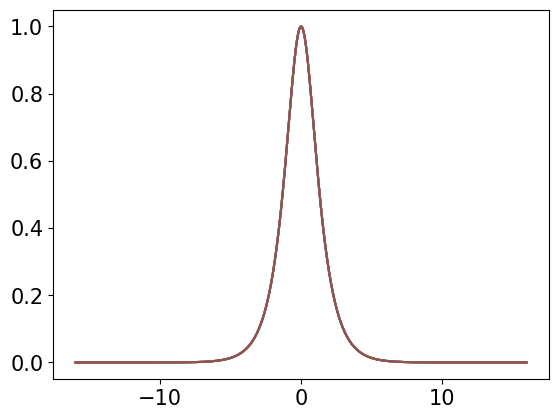

In [17]:
#########       Setup and Run Numerical Experiment

dt=0.0001     ## Choose dt


# Choose ImEx Scheme, options are None,a,b,c
imex_sch = "a"
A_im,A_ex,C,b_im,b_ex,imex_stages = choose_imex(imex_sch)  

# Initialize imex table for simulation
imx = ImEx(imex_stages,A_im,A_ex,b_im,b_ex)


# List of tau values for which u wanna run simulation
tau_list = [1.0/np.power(10.0,i) for i in range(6)]#[1.0/np.power(2.0,i) for i in range(9)]#,0.01,0.1]
inv_list = [H,I1,I2]
frame_dict_list = []
t_list = []
#ini_type = "petviashvili" 
ini_type = "3_solitons"
#s1,c1=setup_tau(imx,dt,xi,0.001)
for tau in tau_list:

    ## Options petviashvili,cubic
    ###  LOAD Initial conditions and grid setup i.e. x,xi,m,L,T,kppa,etc.
    
    if ini_type == "petviashvili":
        rname = "ini_conditions/petviashvili.py "+str(tau)
        %run   $rname
        #L =40.0*np.pi
        x = np.arange(-m/2,m/2)*(L/m)
        xi = np.fft.fftfreq(m)*m*2*np.pi/L
        print("Yo",tau,xi.shape,L,40.0*np.pi,m)
        
    elif ini_type == "cubic":
        %run ini_conditions/cubic.py
    elif ini_type == "2_solitons":
        %run ini_conditions/solitons.py 2
    elif ini_type == "3_solitons":
        %run ini_conditions/solitons.py 3

    q0_ini  = sol
    q1_ini  = dx_sol
    u_ini = np.stack((q0_ini,q1_ini),axis=1)
    plt.plot(x,np.abs(u_ini[:,0]))
    
    lmda_list = setup_tau(imx,dt,xi,tau)
    frm,tt,inv_change_dict,inv_fin,errs = run_nls_hyper_example(dt,x,xi,kppa,T,tau,lmda_list,imx,inv_list,exact_soln_np)
    frame_dict_list.append({"tau":tau,"ini_type":ini_type,"scheme":imex_sch,"frame_list":frm,"t_list":tt,"inv_change_dict":inv_change_dict,"inv_final":inv_fin,"errors":errs,"x":x,"xi":xi,"kappa":kppa,"dt":dt,"m":m})
    print("inv_fin",inv_fin)


import pickle
case=ini_type+"_imex_"+imex_sch+"_"+str(m)+"_"+str(dt)
save_dir = "./data/"+ini_type
if not(os.path.exists(save_dir)):
    os.makedirs(save_dir)
file_name = save_dir+"/"+case+"_tau.pkl"
# Save lists of dicts containing lists of frames & corresponding times for each tau in a file
with open(file_name, 'wb') as f:
    pickle.dump(frame_dict_list,f)

#ldecp = [[[chk[i],-omega[i]],[-bta[i],chk[i]*1j/tau]] for i in range(len(xi))]
#f = np.array([[rho0[i],q0[i]] for i in range(len(x))])
#dtl = -bta+omega
    
#lmdamat = [[-(bta/dtl), omega/dtl],[-(1.0/dtl), 1.0/dtl]]

import pickle
#file_name = "cubic_imex_a__tau.pkl"
#file_name = "3_soliton_imex_a__tau.pkl"


tau=0.001
file_name_ini="Petviashvilil_0.001_ini.pk"

res=15
if res==15:   
    file_name_ini="Petviashvilil_0.001_ini.pk"
    with open(file_name_ini, 'rb') as f:
        fdict = pickle.load(f)
        v = fdict["v"]
        p = fdict["p"]
        x_ref = fdict["x"]
        xi = fdict["xi"]
        kppa = fdict["kppa"]
        mu = fdict["mu"]

    def exact_soln_np(t,x,kppa,v=v,p=p):
            exp_fac = np.exp(1j*mu*t)
            q0 = exp_fac*v
            q1 = exp_fac*p
            return q0
    file_name = "petviashvili_imex_a__tau.pkl"
else:
    rname = "ini_conditions/petviashvili.py "+str(tau)
    %run   $rname
    file_name = "petviashvili_imex_a_test_tau.pkl"
   
     




with open(file_name, 'rb') as f:
    frame_dict_list = pickle.load(f)




0.1

In [14]:
inv_fin

[-5.515006654808301, -16.434719852395602, -5.056865415437816e-09]

In [18]:
#file_name
#with open(file_name, 'rb') as f:
#    frame_dict_list=pickle.load(f)

def plot_H_error_wrt_tau(file_n,change_type="relative change",save_fig_name=None):

    if type(file_n)==list:
        frame_dict_list = file_n
    
        
    else:
        with open(file_n, 'rb') as f:
            frame_dict_list=pickle.load(f)
        #
       
    ini_type = frame_dict_list[0]["ini_type"]
    if save_fig_name==None:
        save_fig_name = "./data/"+ini_type+"/"+"H_Error_"+ini_type+".png"



    tau_list = [f["tau"] for f in frame_dict_list]


    rel_H_list=[]
    err_L1_list=[]
    err_L2_list=[]
    err_Linf_list=[]

    for tau,f in zip(tau_list,frame_dict_list):

        err_L1 = f["errors"][0]
        err_L2 = f["errors"][1]
        err_Linf = f["errors"][2]

        rel_H_list.append(f["inv_change_dict"][change_type][0])
        err_L1_list.append(err_L1)
        err_L2_list.append(err_L2)
        err_Linf_list.append(err_L1)


    fig = plt.figure(figsize=[23,10])
    fig.suptitle('Case='+ini_type.replace("_"," "), fontsize=20)

    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    if change_type=="change":
        ax1.set_ylabel("$H_f-H_i$",fontsize=20)
    else:
        ax1.set_ylabel(r"$\frac{|H_f-H_i|}{H_i}$",fontsize=25)

    ax1.set_yscale("log")
    ax1.set_xscale("log")
    ax1.set_xlabel(r"$\tau$",fontsize=20)
    ax1.tick_params(axis='both', which='major', labelsize=20)

    ax1.plot(tau_list,rel_H_list,"*-")




    ax2.set_yscale("log")
    ax2.set_xscale("log")
    ax2.set_xlabel(r"$\tau$",fontsize=20)

    ax2.set_ylabel("Error",fontsize=20)
    ax2.tick_params(axis='both', which='major', labelsize=20)


    ax2.plot(tau_list,err_Linf_list,"o-",label=r"$L_{\inf}$")
    ax2.plot(tau_list,err_L2_list,"*-",label="$L_2$ ")

    ax2.legend(loc="best",fontsize=20)
    
    
    plt.savefig(save_fig_name)
    return fig


def plot_1x2_sol(fname,tau=None,ilist=None,exact_soln_np=None,x_lim=None,y_lim=None):

        if type(fname)==dict:
             fdict = fname
        elif type(fname)==list:
             for f in fname:
                  tau_c = f['tau']
                  if tau==tau_c:
                       fdict = f
           
        elif type(fname)==str:
             with open(fname, 'rb') as f:
                frame_dict_list=pickle.load(f)
             for f in frame_dict_list:
                  tau_c = f['tau']
                  
                  if tau==tau_c:
                       fdict = f
             

        frames_list = fdict['frame_list']
        t_list = fdict['t_list']
        x = fdict['x']
        xi = fdict['xi']
        kppa = fdict['kappa']
        if exact_soln_np!=None:
                frames_sol = [exact_soln_np(t*np.ones_like(x),x,kppa) for t in t_list]
                print(len(frames_list),frames_sol[0].shape)
       
        n=len(t_list)
        print(len(frames_list))

        fig = plt.figure(figsize=[20,10])
        fig.suptitle(r"Solution with $\tau=$"+str(tau))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        ax1.set_ylabel("$Re(q_0)$")
        ax2.set_ylabel("$Im(q_0)$")

        ax1.set_xlabel("x")
        ax2.set_xlabel("x")

       

        if x_lim!=None:
            ax1.set_xlim(x_lim)
            ax2.set_xlim(x_lim)
        if y_lim!=None:
            ax1.set_ylim(y_lim)
            ax2.set_ylim(y_lim)
        if ilist is None:
             ilist = [i for i in range(0,n,18)]
        for i in ilist:
                ax1.plot(x,np.real(frames_list[i][:,0]),label="t="+str(t_list[i])[:3])
                if exact_soln_np!=None:
                    ax1.plot(x,np.real(frames_sol[i][:]),"+",label="sol t="+str(t_list[i])[:3])

                ax2.plot(x,np.imag(frames_list[i][:,0]),label="t="+str(t_list[i])[:3])
                if exact_soln_np!=None:
                    ax2.plot(x,np.imag(frames_sol[i][:]),"+",label="sol t="+str(t_list[i])[:3])

        ax1.legend(loc="best")
        ax2.legend(loc="best")

        return fig


def plot_1x2_sol_at_t_diff_tau(fname,i=-1,exact_soln_np=None,x_lim=None,y_lim=None):

        tau_list = []
        u_list = []
        t_list=[]
        if type(fname)==list:
             frame_dict_list =fname
             
                  
           
        elif type(fname)==str:
             with open(fname, 'rb') as f:
                frame_dict_list=pickle.load(f)
             
        for f in frame_dict_list:
            tau_list.append(f['tau'])
            t_list.append(f["t_list"][i])
            u_list.append(f["frame_list"][-1])
             

        t = t_list[0]
        print("t_list",t_list)
        
        x = frame_dict_list[0]['x']
        xi = frame_dict_list[0]['xi']
        kppa = frame_dict_list[0]['kappa']
        if exact_soln_np!=None:
                u_sol = exact_soln_np(t*np.ones_like(x),x,kppa)
                print(u_sol.shape)
       
        n=len(t_list)
        

        fig = plt.figure(figsize=[20,10])
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)

        ax1.set_ylabel("$Re(q_0)$")
        ax2.set_ylabel("$Im(q_0)$")

        ax1.set_xlabel("x")
        ax2.set_xlabel("x")

       

        if x_lim!=None:
            ax1.set_xlim(x_lim)
            ax2.set_xlim(x_lim)
        if y_lim!=None:
            ax1.set_ylim(y_lim)
            ax2.set_ylim(y_lim)
        
        if exact_soln_np!=None:
                    ax1.plot(x,np.real(u_sol[:]),"+",label="sol")
        if exact_soln_np!=None:
                    ax2.plot(x,np.imag(u_sol[:]),"+",label="sol")

                    
        for j,tau in enumerate(tau_list):
                ax1.plot(x,np.real(u_list[j][:,0]),label=r"$\tau=$"+str(tau))
                

                ax2.plot(x,np.imag(u_list[j][:,0]),label=r"$\tau=$"+str(tau))
                

        ax1.legend(loc="best")
        ax2.legend(loc="best")

        fig.suptitle("Solutions @ t="+str(t))
        return fig


    


51 (2048,)
51
t_list [4.9001, 4.9001, 4.9001, 4.9001, 4.9001, 4.9001]
(2048,)


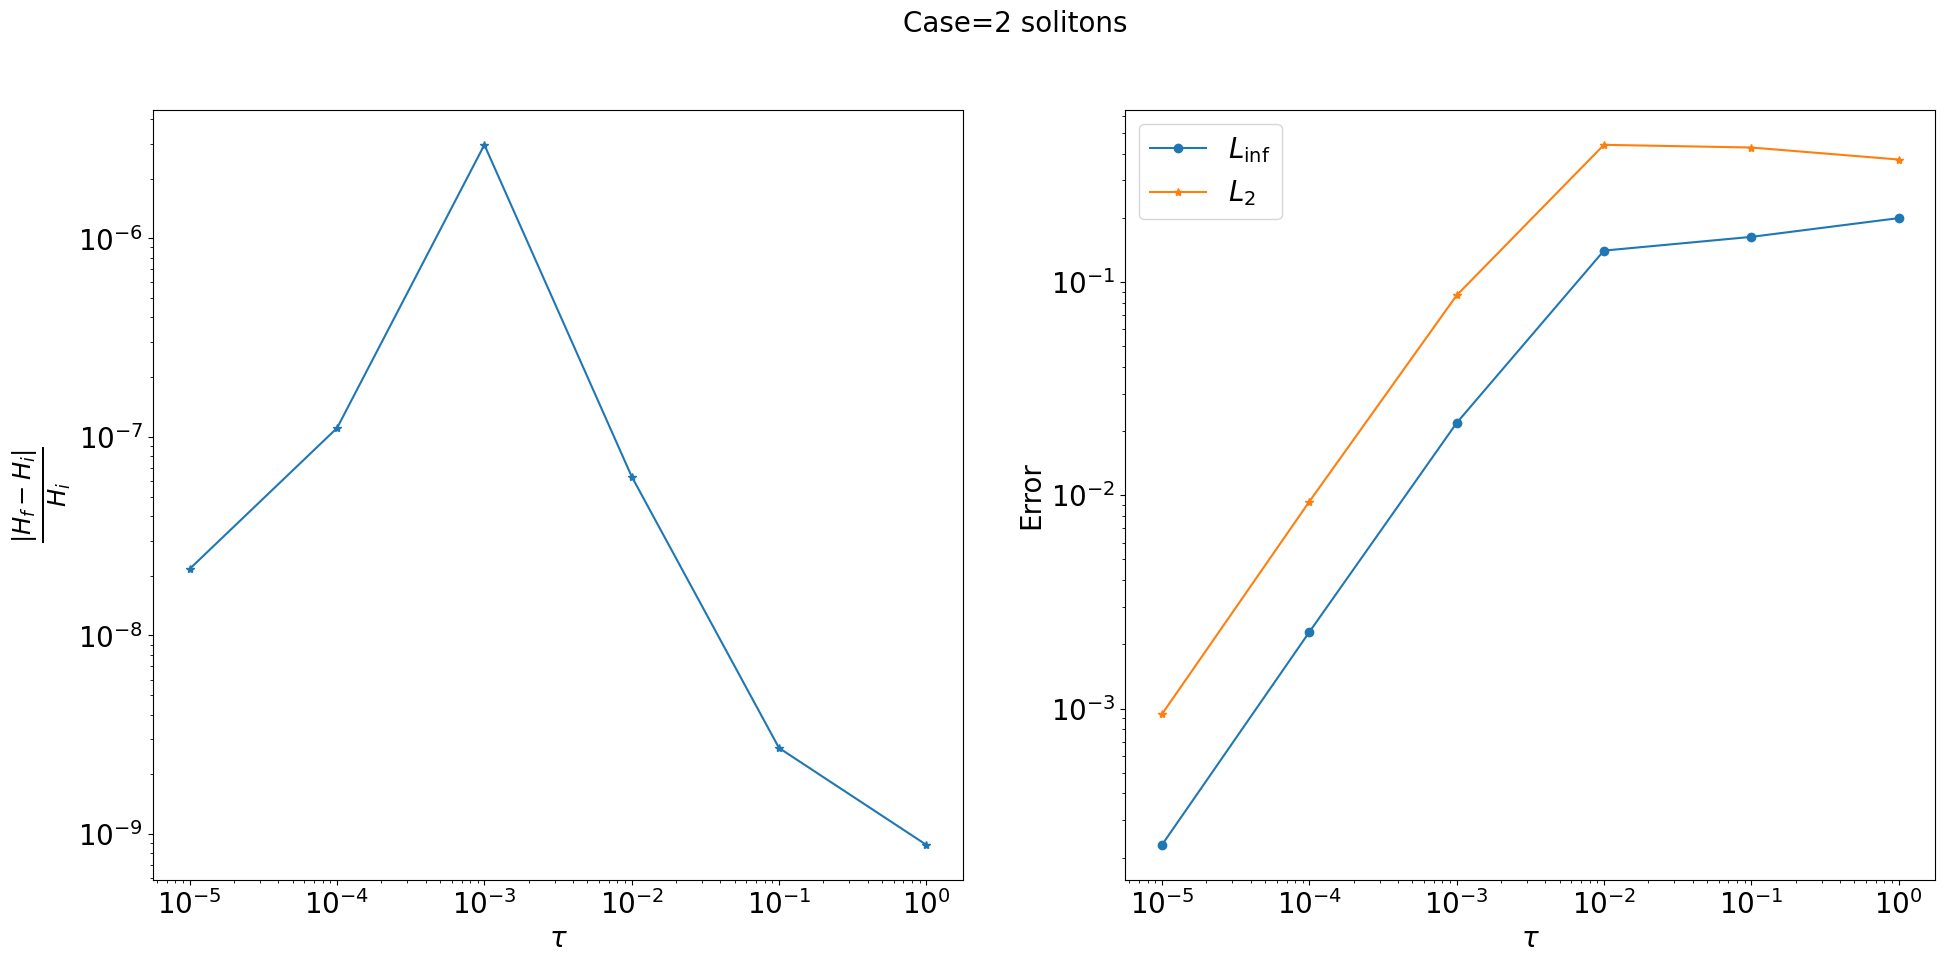

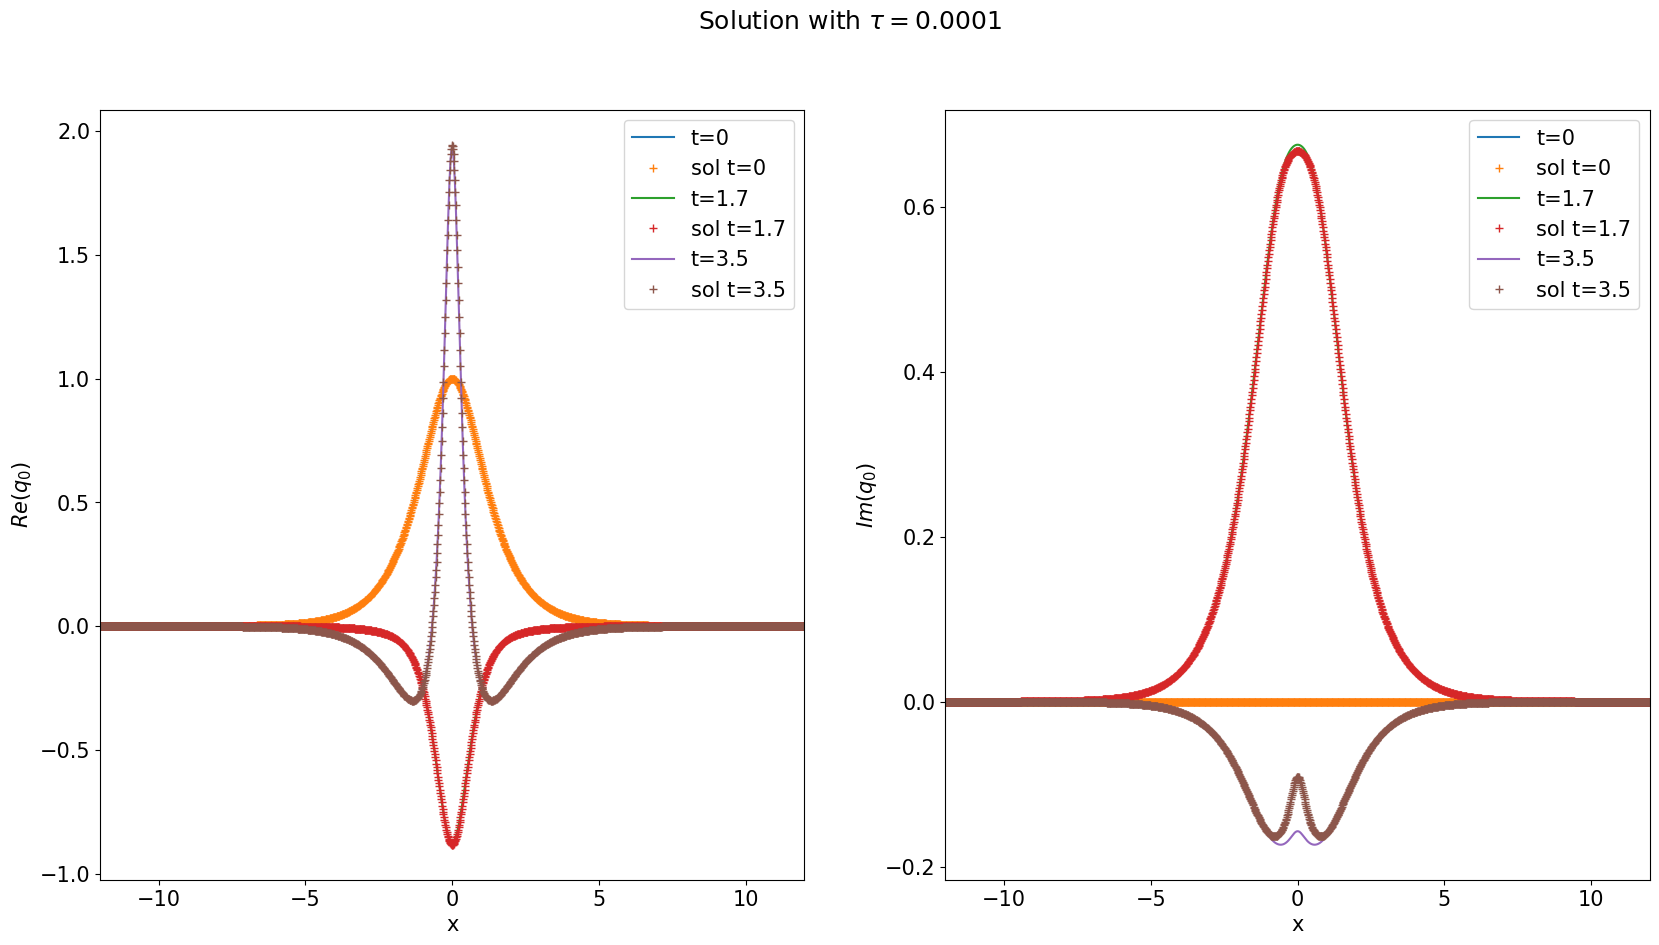

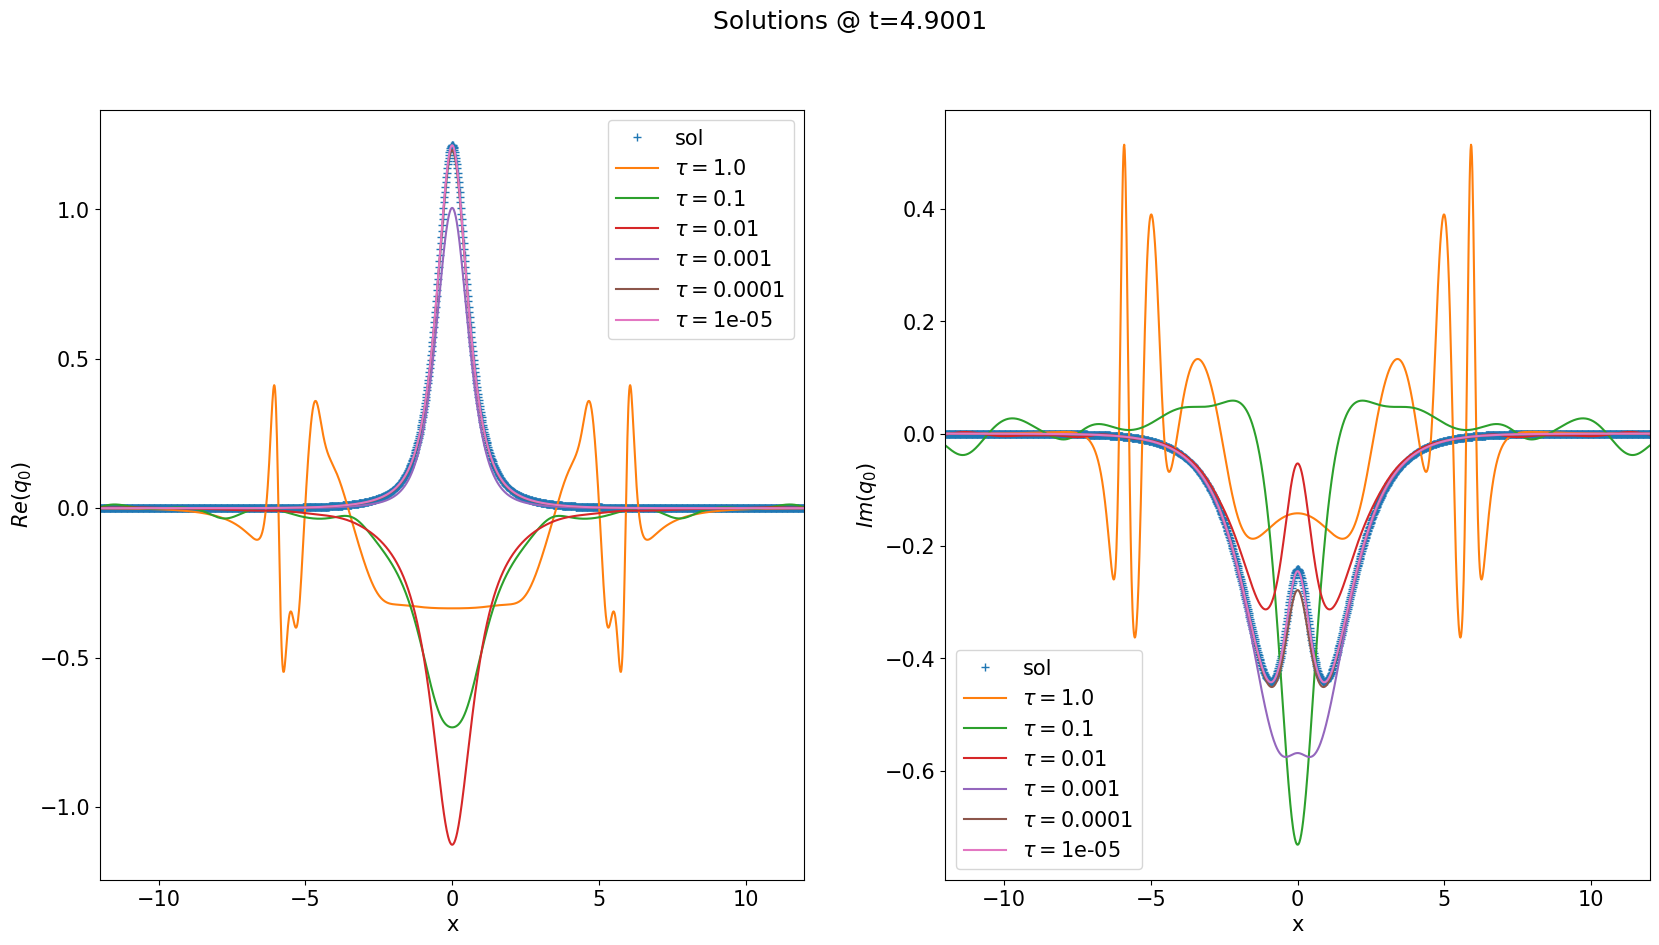

In [19]:
#%run ini_conditions/solitons.py 2
filename= "/Users/rajvanmp/station_X/pyGP_fields/hyperbolization/data/2_solitons/2_solitons_imex_a_2048_0.0001_tau.pkl"
plot_dir = "./data/2_solitons/"
if not(os.path.exists(plot_dir)):
    os.makedirs(plot_dir)
plot_H_error_wrt_tau(filename,save_fig_name=plot_dir+"H_Error_2_solitons")

figr_a = plot_1x2_sol(filename,tau=0.0001,exact_soln_np=exact_soln_np,x_lim=[-12.0,12.0])
figr_a.savefig(plot_dir+"2_solitons_soln.png")

figr_b = plot_1x2_sol_at_t_diff_tau(filename,exact_soln_np=exact_soln_np,x_lim=[-12.0,12.0])
figr_b.savefig(plot_dir+"2_solitons_final_time.png")

No of solitons in ini. cond. is 3
3 soliton selected
<class 'numpy.ndarray'> complex128
51 (2048,)
51
t_list [4.9001, 4.9001, 4.9001, 4.9001, 4.9001, 4.9001]
(2048,)


<Figure size 640x480 with 0 Axes>

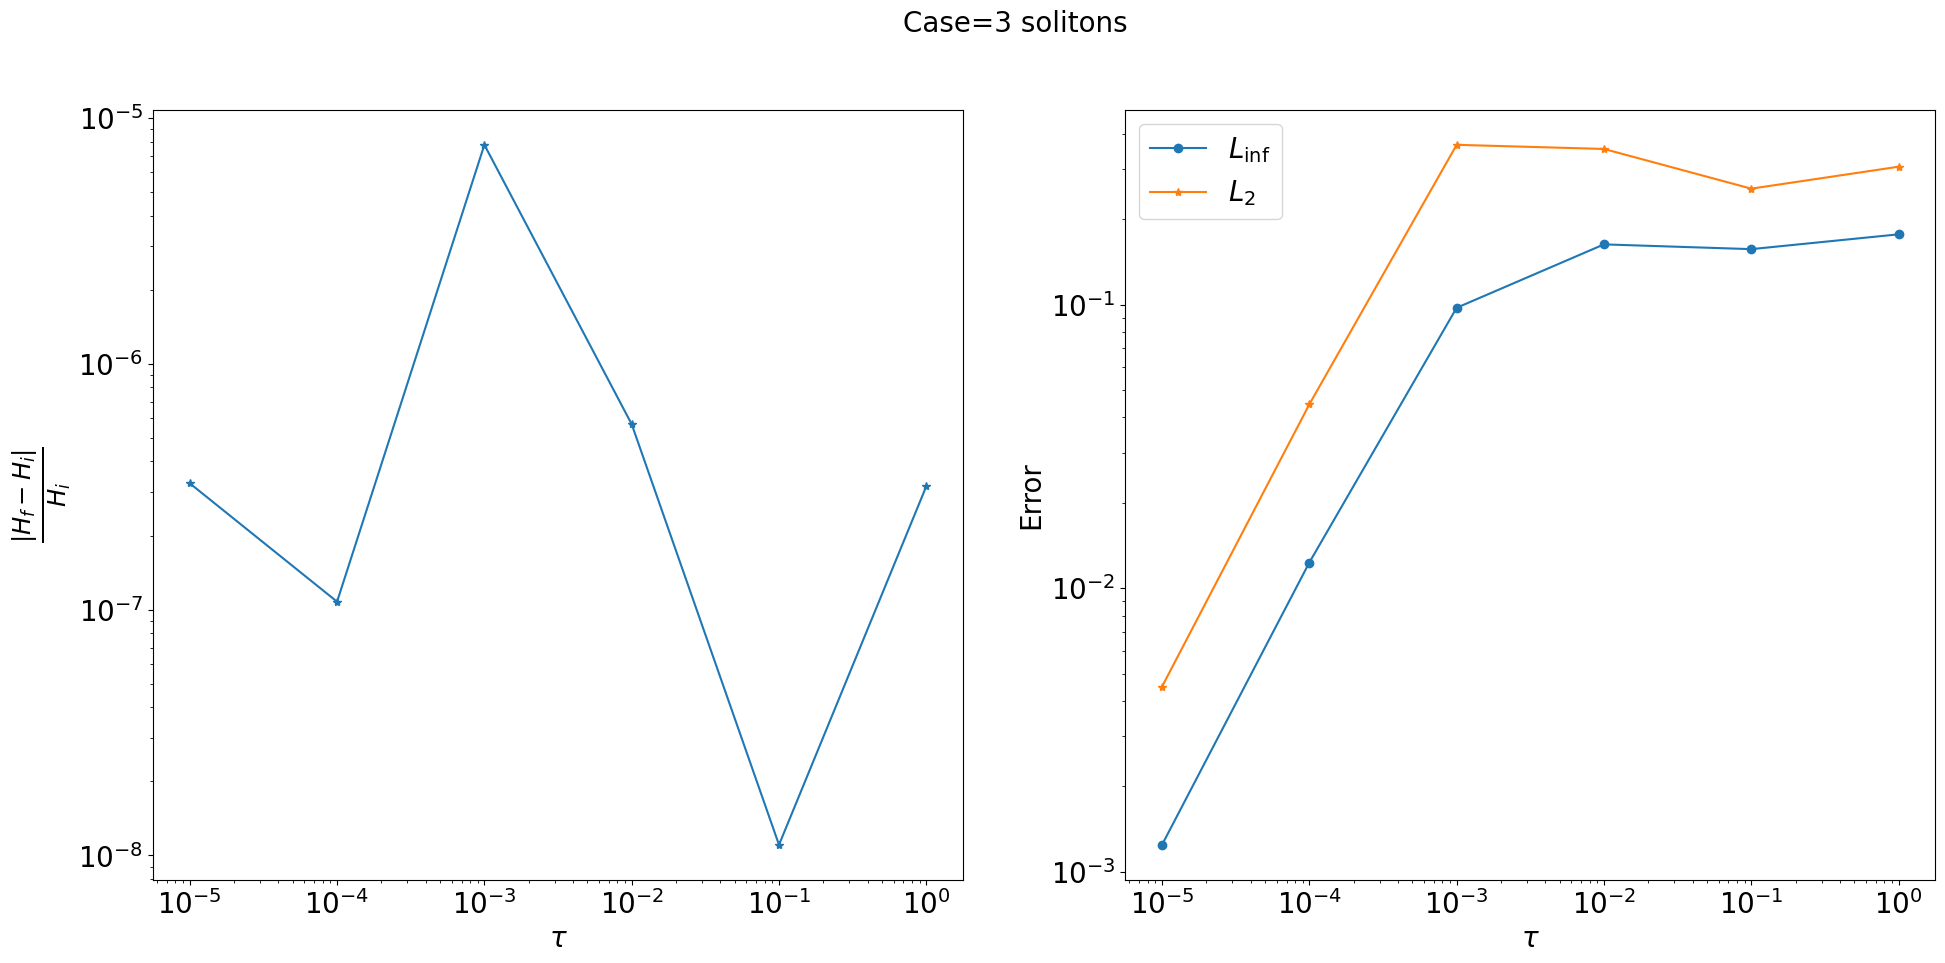

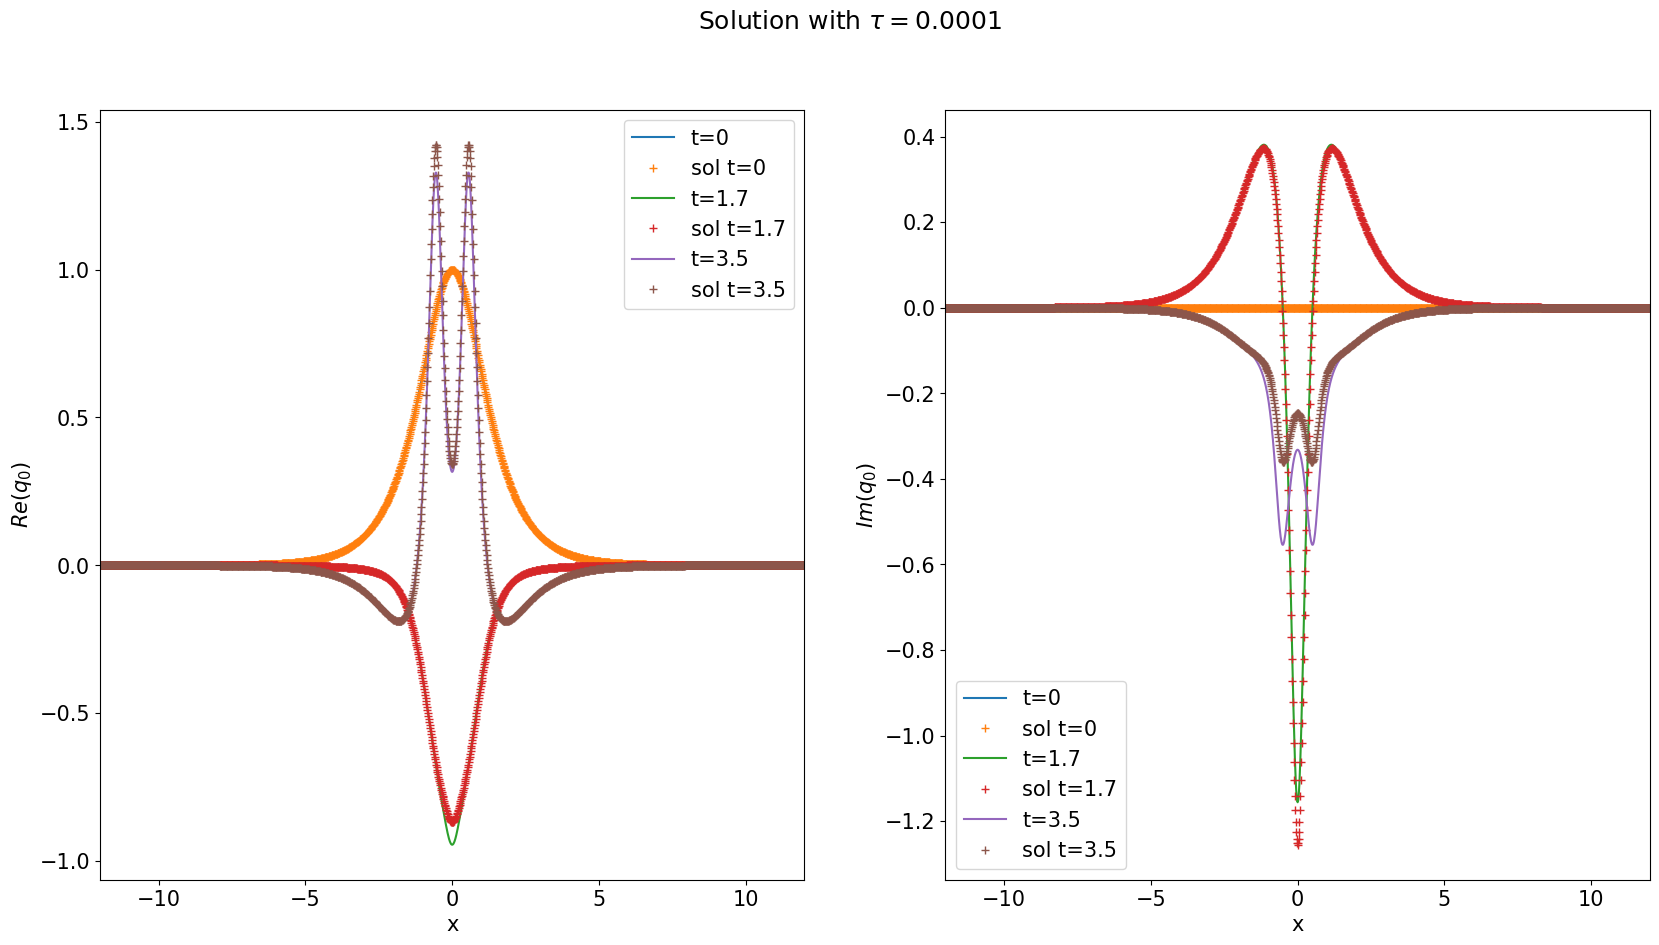

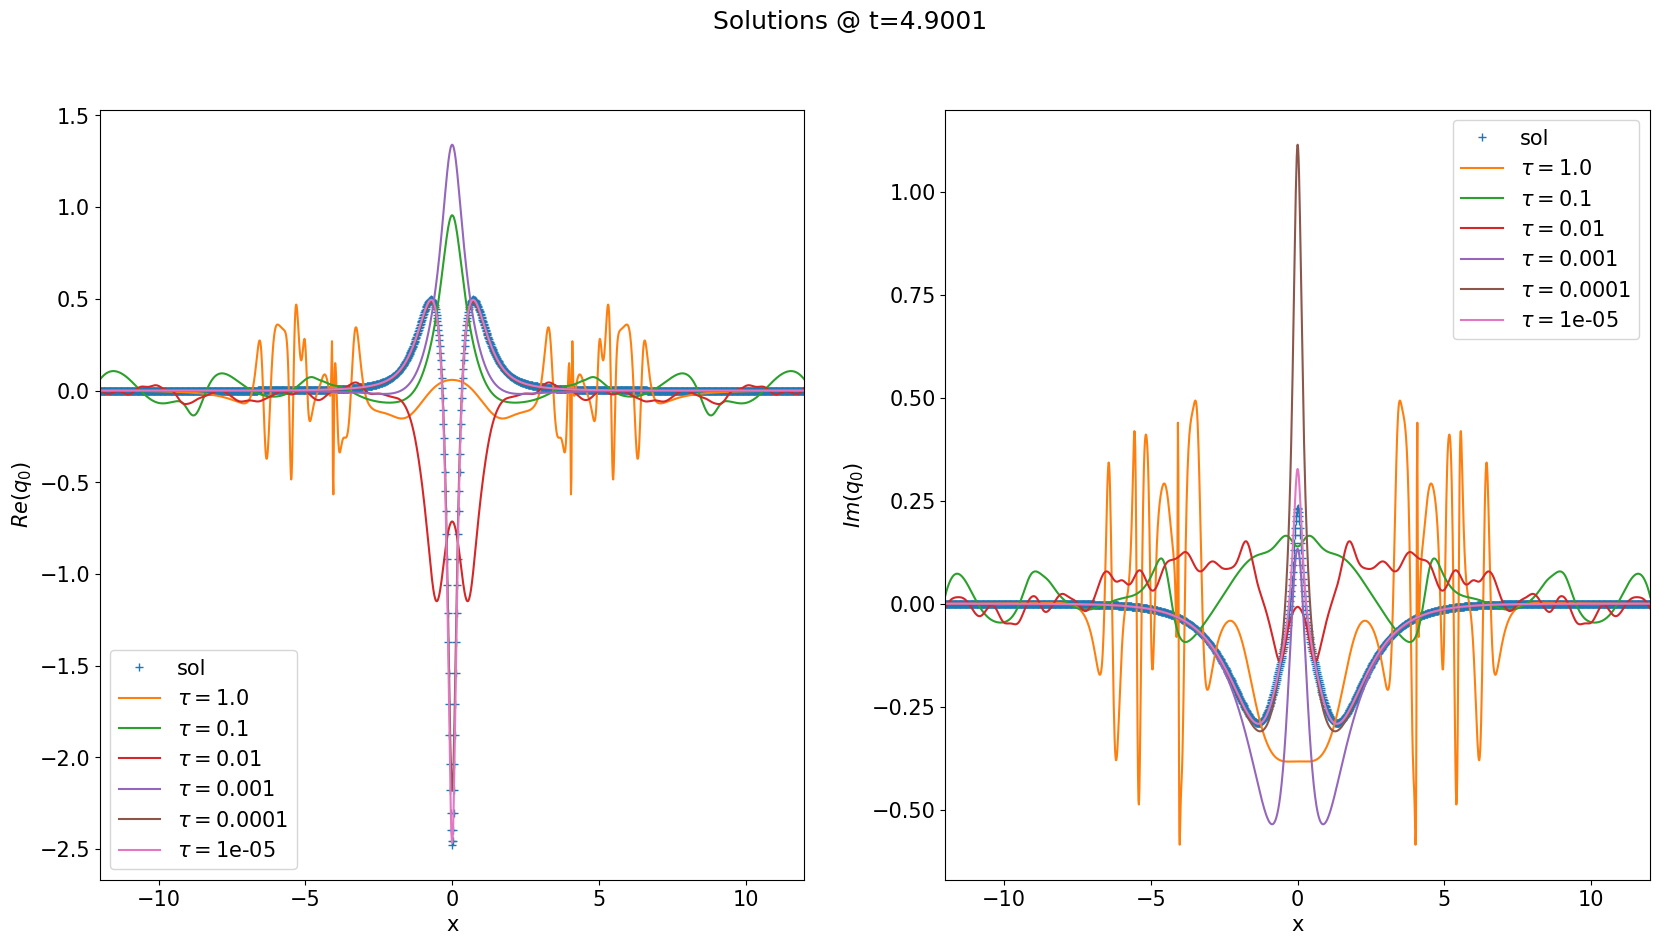

In [20]:
%run ini_conditions/solitons.py 3
filename= "/Users/rajvanmp/station_X/pyGP_fields/hyperbolization/data/3_solitons/3_solitons_imex_a_2048_0.0001_tau.pkl"
plot_dir = "./data/3_solitons/"
if not(os.path.exists(plot_dir)):
    os.makedirs(plot_dir)

plot_H_error_wrt_tau(filename,save_fig_name=plot_dir+"H_Error_3_solitons")

figr_a = plot_1x2_sol(filename,tau=0.0001,exact_soln_np=exact_soln_np,x_lim=[-12.0,12.0])
figr_a.savefig(plot_dir+"3_solitons_soln.png")

figr_b = plot_1x2_sol_at_t_diff_tau(filename,exact_soln_np=exact_soln_np,x_lim=[-12.0,12.0])
figr_b.savefig(plot_dir+"3_solitons_final_time.png")

In [53]:
def plot_tau_compare(f_list,exct_fnc,plot_type="real",plot_type2="none"):
    tau_list = [f["tau"] for f in f_list]
    x = f_list[0]["x"]
    xi = f_list[0]["x"]
    kppa = f_list[0]["kappa"]
    tt = f_list[0]["t_list"]
    
    print("Tau list",tau_list)
    clist = ["r-","g--","b.--","k-","m--","c.--"]
    lablist= [r"$\tau =$" for i in range(len(tau_list)) ]
    lablist= [lablist[i]+str(tau_list[i]) for i in range(len(tau_list))]

    frame_list = [t["frame_list"] for t in f_list]
   
   
    frames_sol = [exct_fnc(t*np.ones_like(x),x,kppa) for t in tt]
    if plot_type=="real":
        frame_list = [np.real(f) for f in frame_list]
        #frames = np.real(frames)
        frames_sol=np.real(frames_sol)
    elif plot_type=="imag":
        frame_list = [np.imag(f) for f in frame_list]
        #frames=np.imag(frames)
        frames_sol = np.imag(frames_sol)
    else:
        frame_list = [np.square(np.abs(f)) for f in frame_list]
        #frames=np.square(np.abs(frames))
        frames_sol = np.square(np.abs(frames_sol))
    fig = plt.figure(figsize=(12,8))
    axes = fig.add_subplot(211)
    axes2 = fig.add_subplot(212)
    line_list  = [ axes.plot(x,frames_sol[0][:],"-*",lw=3,label="sol")[0]]
    line_list2 = []
    for j,f in enumerate(frame_list):
        line_list.append(axes.plot(x,f[0][:,0],clist[j],lw=3,label=lablist[j])[0])
        line_list2.append(axes2.plot(x,f[0][:,1],clist[j],lw=3,label=lablist[j])[0])
    
    
    

    
    
    #axes2.semilogy([xi_max/2.,xi_max/2.],[1.e-6,4e8],'--r')
    #axes2.semilogy([-xi_max/2.,-xi_max/2.],[1.e-8,4e10],'--r')
    
    axes.set_ylabel(r'$q0$',fontsize=30)
    axes2.set_ylabel(r'$q1$',fontsize=30)
    plt.tight_layout()
    axes.legend(loc="best")
    axes2.legend(loc="best")
    plt.close()

    def plot_frame(i):
       
        line_list[0].set_data(x,frames_sol[i][:])
        #power_spectrum = np.abs(uuhat[i])**2
        for j,f in zip(range(len(frame_list)),frame_list):
            line_list[j+1].set_data(x,f[i][:,0])
            line_list2[j].set_data(x,f[i][:,1])

        
        
        
        axes.set_title('t= %.2e' % tt[i])
        axes.set_xlim((-8.0,8.0))
        axes.set_ylim((-2.0,2.5))
        axes2.set_xlim((-8.0,8.0))
        axes2.set_ylim((-2.0,20.0))

    anim = matplotlib.animation.FuncAnimation(fig, plot_frame,
                                              frames=len(frame_list[0]), interval=100,
                                              repeat=False)
    return HTML(anim.to_jshtml())

Tau list [1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625]


IndexError: list index out of range

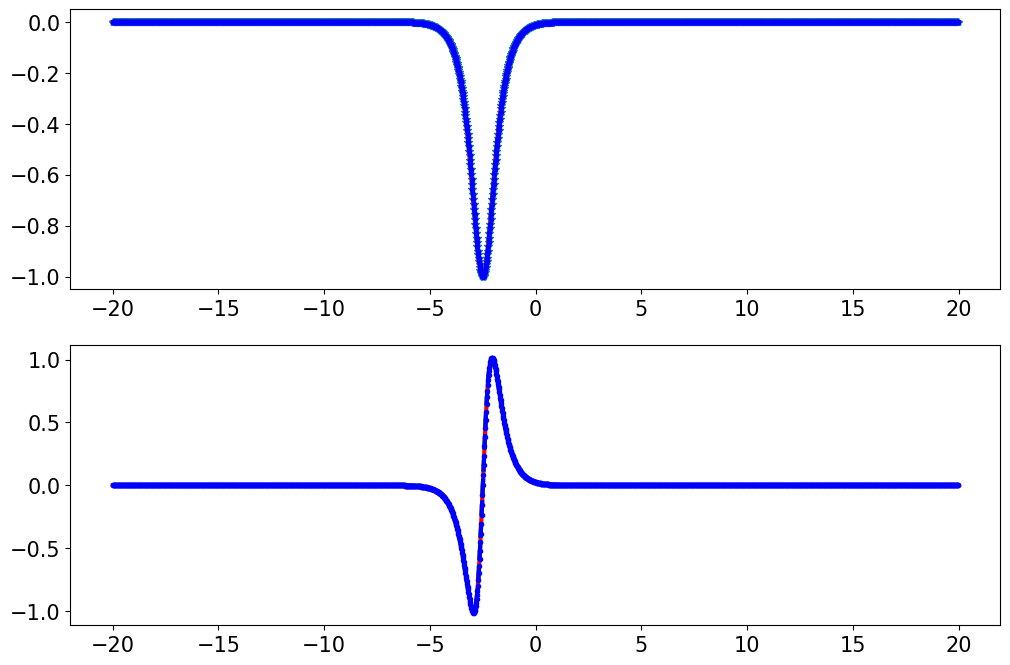

In [54]:
plot_tau_compare(frame_dict_list,exct_fnc=exact_soln_np,plot_type="real")

In [39]:
#########################     "Petviashvili"   plots  #########################


[512, 1024, 2048, 4096, 8192, 16384]


In [63]:

m_list = [2**i for i in range(9,14)]
ini_type = "petviashvili" 
imex_sch = "a"
dt = 0.0001

dt_file_list = ["./data/"+ini_type+"_imex_"+imex_sch+"_"+str(m)+"_"+str(dt)+"_tau.pkl" for m in m_list]
print(dt_file_list)
# Save lists of dicts containing lists of frames & corresponding times for each tau in a file
fdict_list = []
for file_nm in dt_file_list:
    print(file_nm)
    with open(file_nm, "rb") as f:
        fdict_list.append(pickle.load(f))
    print(len(fdict_list))




rel_H_dxlist=[]
err_L1_dxlist=[]
err_L2_dxlist=[]
err_Linf_dxlist=[]

for m,f in zip(m_list,fdict_list):

    err_L1 = f[0]["errors"][0]
    err_L2 = f[0]["errors"][1]
    err_Linf = f[0]["errors"][2]

    rel_H_dxlist.append(f[0]["inv_change_dict"][change_type][0])
    err_L1_dxlist.append(err_L1)
    err_L2_dxlist.append(err_L2)
    err_Linf_dxlist.append(err_L1)
    
    #print(f["inv_change"][0])
    #plt.plot(tau,f["inv_change"][1],"*",label=r"I1, $\tau=$"+str(tau))
    #plt.plot(tau,f["inv_change"][2],"^",label=r"I2, $\tau=$"+str(tau))
#plt.legend(loc="best")


['./data/petviashvili_imex_a_512_0.0001_tau.pkl', './data/petviashvili_imex_a_1024_0.0001_tau.pkl', './data/petviashvili_imex_a_2048_0.0001_tau.pkl', './data/petviashvili_imex_a_4096_0.0001_tau.pkl', './data/petviashvili_imex_a_8192_0.0001_tau.pkl']
./data/petviashvili_imex_a_512_0.0001_tau.pkl
1
./data/petviashvili_imex_a_1024_0.0001_tau.pkl
2
./data/petviashvili_imex_a_2048_0.0001_tau.pkl
3
./data/petviashvili_imex_a_4096_0.0001_tau.pkl
4
./data/petviashvili_imex_a_8192_0.0001_tau.pkl
5


['./data/petviashvili_imex_a_1024_0.015625_tau.pkl', './data/petviashvili_imex_a_1024_0.0078125_tau.pkl', './data/petviashvili_imex_a_1024_0.00390625_tau.pkl', './data/petviashvili_imex_a_1024_0.001953125_tau.pkl', './data/petviashvili_imex_a_1024_0.0009765625_tau.pkl', './data/petviashvili_imex_a_1024_0.00048828125_tau.pkl', './data/petviashvili_imex_a_1024_0.000244140625_tau.pkl']
./data/petviashvili_imex_a_1024_0.015625_tau.pkl
1
./data/petviashvili_imex_a_1024_0.0078125_tau.pkl
2
./data/petviashvili_imex_a_1024_0.00390625_tau.pkl
3
./data/petviashvili_imex_a_1024_0.001953125_tau.pkl
4
./data/petviashvili_imex_a_1024_0.0009765625_tau.pkl
5
./data/petviashvili_imex_a_1024_0.00048828125_tau.pkl
6
./data/petviashvili_imex_a_1024_0.000244140625_tau.pkl
7


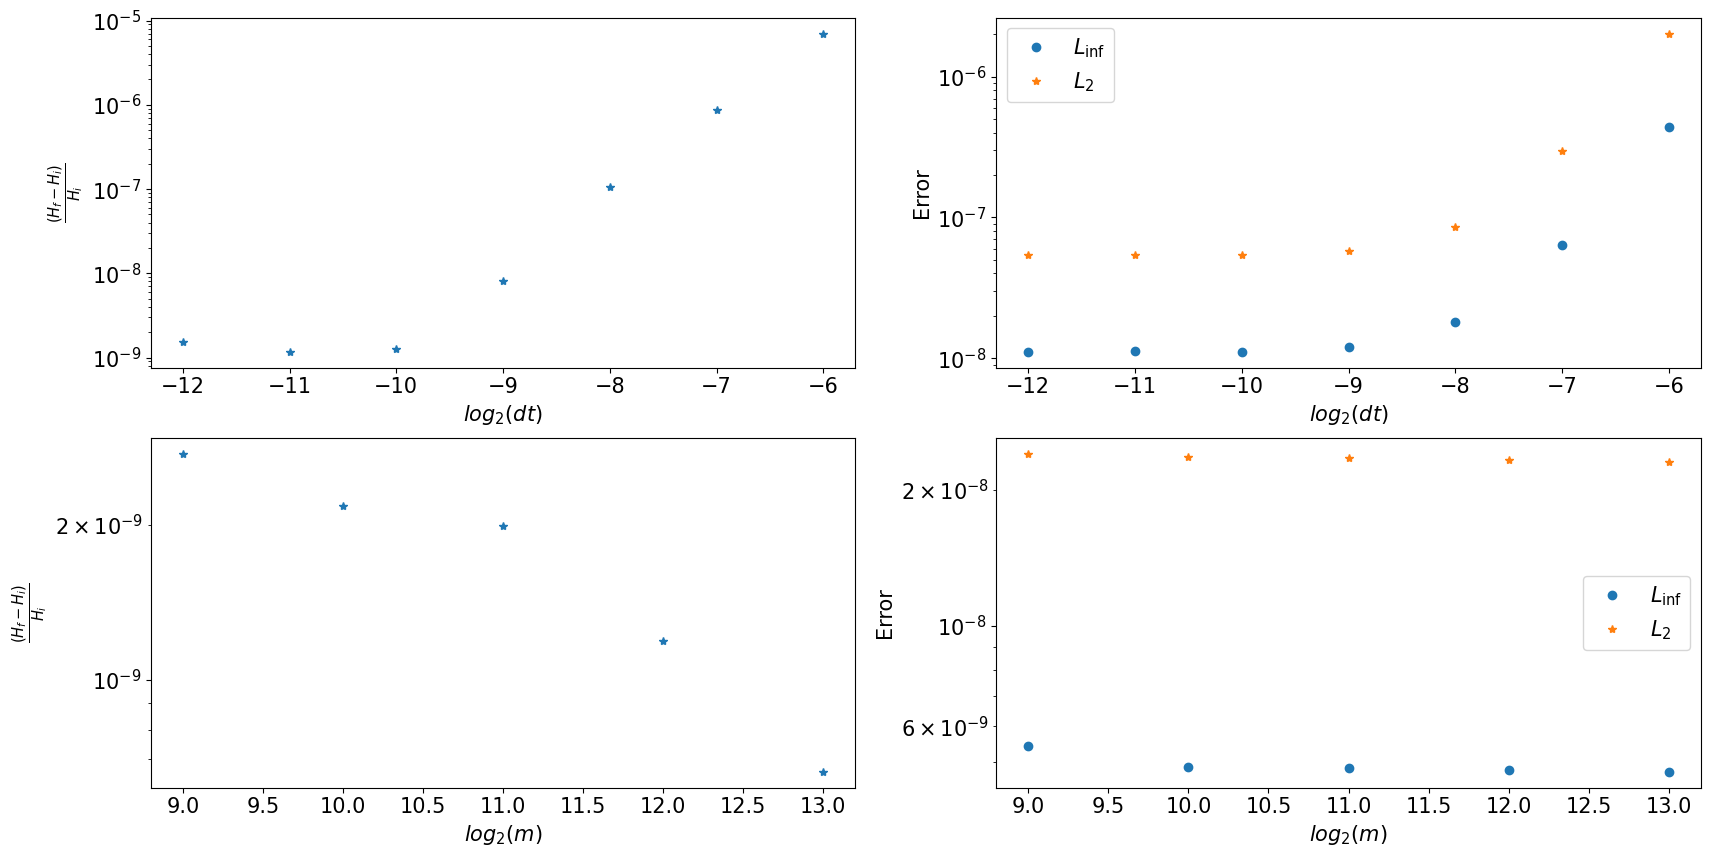

In [68]:
dt_list = [1.0/np.power(2.0,i) for i in range(6,13)]
ini_type = "petviashvili" 
imex_sch = "a"
m = 1024



dt_file_list = ["./data/"+ini_type+"_imex_"+imex_sch+"_"+str(m)+"_"+str(dt)+"_tau.pkl" for dt in dt_list]
print(dt_file_list)
# Save lists of dicts containing lists of frames & corresponding times for each tau in a file
fdict_list = []
for file_nm in dt_file_list:
    print(file_nm)
    with open(file_nm, "rb") as f:
        fdict_list.append(pickle.load(f))
    print(len(fdict_list))



rel_H_dtlist=[]
err_L1_dtlist=[]
err_L2_dtlist=[]
err_Linf_dtlist=[]

for dt,f in zip(dt_list,fdict_list):
    err_L1 = f[0]["errors"][0]
    err_L2 = f[0]["errors"][1]
    err_Linf = f[0]["errors"][2]

    rel_H_dtlist.append(f[0]["inv_change_dict"][change_type][0])
    err_L1_dtlist.append(err_L1)
    err_L2_dtlist.append(err_L2)
    err_Linf_dtlist.append(err_L1)





fig = plt.figure(figsize=[20,10])
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


ax1.set_yscale("log")
ax1.set_xlabel(r"$log_2(dt)$")
if change_type=="change":
    ax1.set_ylabel("$H_f-H_i$")
else:
    ax1.set_ylabel(r"$\frac{(H_f-H_i)}{H_i}$")

ax1.plot(np.log2(dt_list),rel_H_dtlist,"*",label="H change")




ax2.set_yscale("log")
ax2.set_xlabel(r"$log_2(dt)$")

ax2.set_ylabel("Error")

ax2.plot(np.log2(dt_list),err_Linf_dtlist,"o",label="$L_{\inf}$")
ax2.plot(np.log2(dt_list),err_L2_dtlist,"*",label="$L_2$ ")



ax2.legend(loc="best")

ax3.set_yscale("log")
ax3.set_xlabel(r"$log_2(m)$")
if change_type=="change":
    ax3.set_ylabel("$H_f-H_i$")
else:
    ax3.set_ylabel(r"$\frac{(H_f-H_i)}{H_i}$")

ax3.plot(np.log2(m_list),rel_H_dxlist,"*",label="H change")


ax4.set_yscale("log")
ax4.set_xlabel(r"$log_2(m)$")

ax4.set_ylabel("Error")

ax4.plot(np.log2(m_list),err_Linf_dxlist,"o",label="$L_{\inf}$")
ax4.plot(np.log2(m_list),err_L2_dxlist,"*",label="$L_2$ ")


ax4.legend(loc="best")


51 (1024, 2)


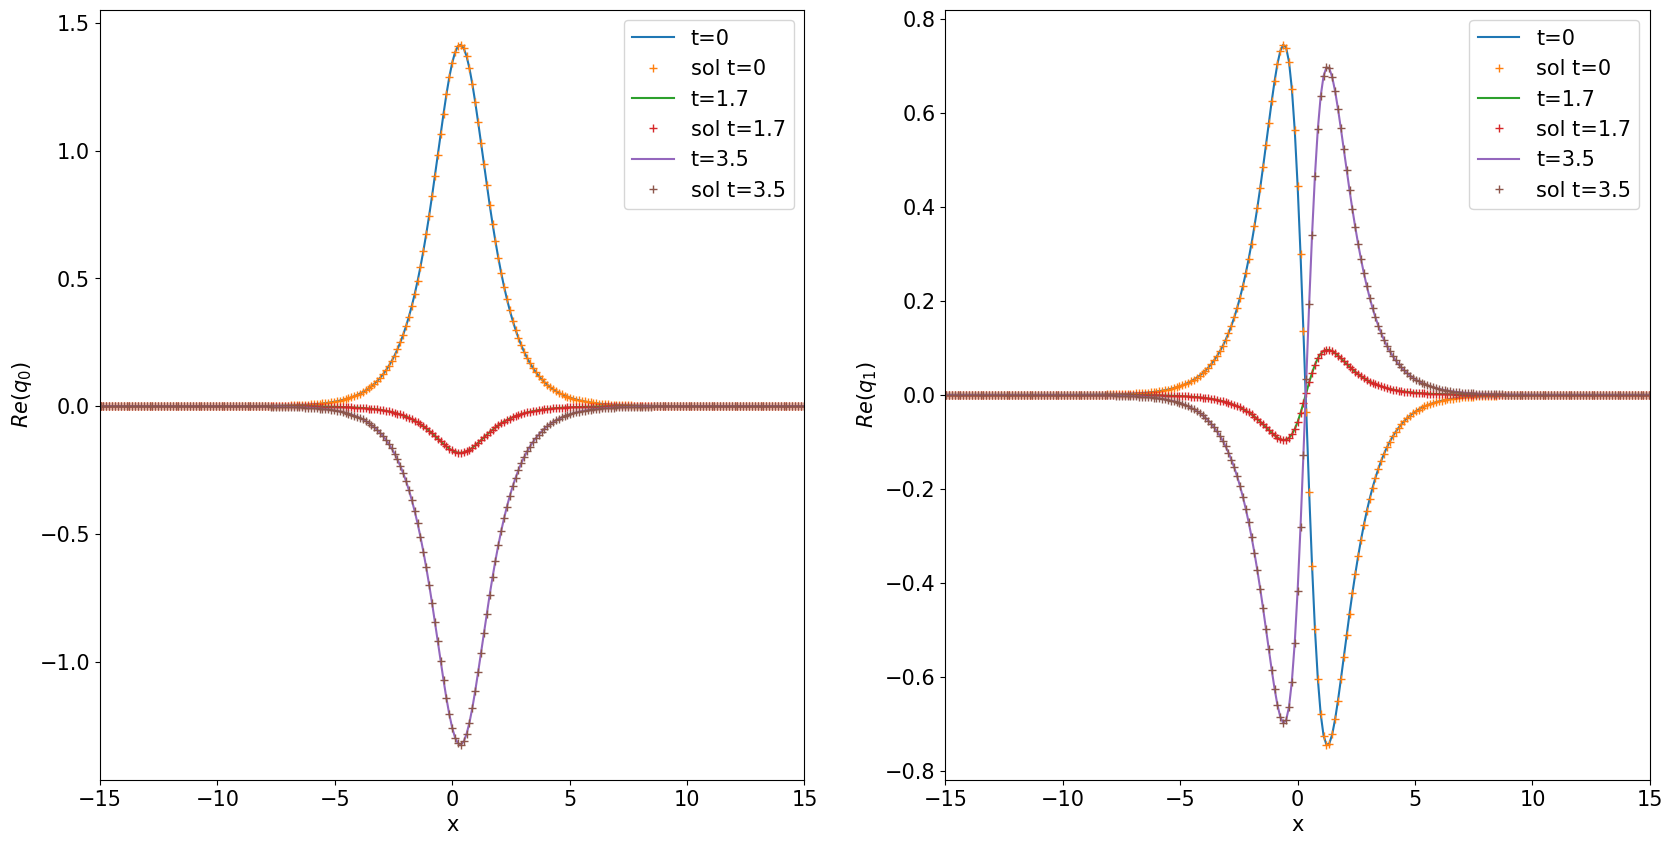

In [110]:
rname = "ini_conditions/petviashvili.py "+str(0.0001)
%run   $rname
        #L =40.0*np.pi
x = np.arange(-m/2,m/2)*(L/m)
xi = np.fft.fftfreq(m)*m*2*np.pi/L



with open("./data/petviashvili_imex_a_1024_0.0001_tau.pkl", "rb") as f:
        fdict=pickle.load(f)[0]
frames_list = fdict['frame_list']
t_list = fdict['t_list']
x = fdict['x']

frames_sol = [exact_soln_np(t*np.ones_like(x),x,kppa) for t in t_list]
n=len(t_list)
print(len(frames_list),frames_sol[0].shape)

fig = plt.figure(figsize=[20,10])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.set_ylabel("$Re(q_0)$")
ax2.set_ylabel("$Re(q_1)$")

ax1.set_xlabel("x")
ax2.set_xlabel("x")




ax1.set_xlim([-15.0,15.0])
ax2.set_xlim([-15.0,15.0])
for i in range(0,n,18):
        ax1.plot(x,np.real(frames_list[i][:,0]),label="t="+str(t_list[i])[:3])
        ax1.plot(x,np.real(frames_sol[i][:,0]),"+",label="sol t="+str(t_list[i])[:3])

        ax2.plot(x,np.real(frames_list[i][:,1]),label="t="+str(t_list[i])[:3])
        ax2.plot(x,np.real(frames_sol[i][:,1]),"+",label="sol t="+str(t_list[i])[:3])

ax1.legend(loc="best")
ax2.legend(loc="best")

dict_keys(['tau', 'scheme', 'frame_list', 't_list', 'inv_change_dict', 'inv_final', 'errors', 'x', 'xi', 'kappa'])